# comparing cosebi & pseudo cl

missing JK  38
missing JK  45
missing JK  161
missing JK  207
missing JK  247
missing JK  266
missing JK  318
missing JK  426
missing JK  440
missing JK  484
missing JK  565
missing JK  568
missing JK  630
missing JK  641
missing JK  657
missing JK  659
missing JK  744
missing JK  761
missing JK  780
chi2 cosebi [dof]: 29.91 , 20 
chi2 pseudo Cl[dof]: 79.19 , 31 
chi2 pseudo Cl (JK)[dof]: 32.25 , 31 


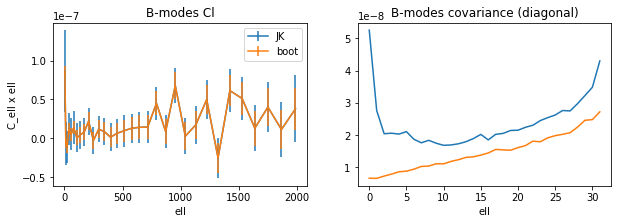

In [245]:
%matplotlib inline
import matplotlib.pyplot as plt

def covariance_jck(TOTAL_PHI,jk_r,type_cov):
  if type_cov=='jackknife':
      fact=(jk_r-1.)/(jk_r)

  elif type_cov=='bootstrap':
      fact=1./(jk_r)
  #  Covariance estimation

  average=np.zeros(TOTAL_PHI.shape[0])
  cov_jck=np.zeros((TOTAL_PHI.shape[0],TOTAL_PHI.shape[0]))
  err_jck=np.zeros(TOTAL_PHI.shape[0])


  for kk in range(jk_r):
    average+=TOTAL_PHI[:,kk]
  average=average/(jk_r)

 # print average
  for ii in range(TOTAL_PHI.shape[0]):
     for jj in range(ii+1):
          for kk in range(jk_r):
            cov_jck[jj,ii]+=TOTAL_PHI[ii,kk]*TOTAL_PHI[jj,kk]

          cov_jck[jj,ii]=(-average[ii]*average[jj]*jk_r+cov_jck[jj,ii])*fact
          cov_jck[ii,jj]=cov_jck[jj,ii]

  for ii in range(TOTAL_PHI.shape[0]):
   err_jck[ii]=np.sqrt(cov_jck[ii,ii])
 # print err_jck

  #compute correlation
  corr=np.zeros((TOTAL_PHI.shape[0],TOTAL_PHI.shape[0]))
  for i in range(TOTAL_PHI.shape[0]):
      for j in range(TOTAL_PHI.shape[0]):
        corr[i,j]=cov_jck[i,j]/(np.sqrt(cov_jck[i,i]*cov_jck[j,j]))

  average=average*fact
  return {'cov' : cov_jck,
          'err' : err_jck,
          'corr':corr,
          'mean':average}

import pyfits as pf
import pickle
import numpy as np
import sys
from compute_Cell_to_COSEBIs_cori import  get_wnlog, old_get_cbb_ell#,get_cbb_ell

def save_obj( name,obj ):
    with open( name + '.pickle', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open( name + '.pickle', 'rb') as f:
        return pickle.load(f)


# Load B-modes measurement *************************************************************
path = '../data/'
n_jck = 1000

# noise only measurement
fil_noise = 'cls_Y3_mastercat_12_3_19_v3_Bmode_non-tomo_highell_nopureE_countmode_C1_apo0.0_nside1024'
B_modes_noise = load_obj(path+fil_noise)

rndm_dv = np.mean(B_modes_noise['galaxy_shear','galaxy_shear'][(0, 0)]['random'],axis=0)[-1]
full_dv = (B_modes_noise['galaxy_shear','galaxy_shear'][(0, 0)]['data'])[-1]
ell= B_modes_noise['ell']
B_modes_arr_boot = np.zeros((len(ell),n_jck+1))
B_modes_arr_boot[:,0]=B_modes_noise['galaxy_shear', 'galaxy_shear'][(0, 0)]['data'][-1,:]-rndm_dv
for i in range(n_jck):
    B_modes_arr_boot[:,i+1]=B_modes_noise['galaxy_shear','galaxy_shear'][(0, 0)]['random'][i,-1,:]-rndm_dv
    


# JK measurements
fil_JK = 'cls_Y3_mastercat_12_3_19_v3_Bmode_JK_non-tomo_highell_nopureE_countmode_C1_apo0.0_nside1024'
B_modes = load_obj(path+fil_JK)

ell= B_modes['ell']
B_modes_arr = np.zeros((len(ell),n_jck+1))
B_modes_arr[:,0]=B_modes['galaxy_shear', 'galaxy_shear'][(0, 0)]['data'][-1,:]-rndm_dv
f=1.#0.98 # 19 jk regions are empty..no variance from them.
for i in range(n_jck):
    try:
        B_modes_arr[:,i+1]=B_modes['galaxy_shear-jk{0}'.format(i), 'galaxy_shear-jk{0}'.format(i)][(0, 0)]['data'][-1,:]-f*rndm_dv
    except:
        print ('missing JK ',i+1)
        B_modes_arr[:,i+1]= (B_modes_arr[:,0])#=B_modes['galaxy_shear', 'galaxy_shear'][(0, 0)]['data'][-1,:]


err_pseudo_cl_boot = covariance_jck(B_modes_arr_boot[:,1:],1000,'bootstrap')

err_pseudo_cl_JK = covariance_jck(B_modes_arr[:,1:],1000,'jackknife')

fig, ax = plt.subplots(1,2, figsize=(10,3))

ax[0].errorbar(ell,err_pseudo_cl['mean']*ell,err_pseudo_cl_JK['err']*ell,label='JK')
ax[0].errorbar(ell,err_pseudo_cl['mean']*ell,err_pseudo_cl_boot['err']*ell,label='boot')
ax[0].legend()

ax[0].set_title('B-modes Cl')
ax[0].set_xlabel('ell')
ax[0].set_ylabel('C_ell x ell')

ax[1].set_title('B-modes covariance (diagonal)')
ax[1].set_xlabel('ell')
ax[1].plot(err_pseudo_cl_JK['err']*ell,label='JK')
ax[1].plot(err_pseudo_cl_boot['err']*ell,label='boot')


# rad COSEBI 
cosebi_b = np.loadtxt(path+'Bn_out_notomoJK1000_select_y3real_12_3_19_v2_2.5_250.0_mean.out')
cosebi_b_cov = np.loadtxt(path+'Bn_out_notomoJK1000_selectshape_y3real_12_3_19_v2_2.5_250.0.cov')
err_b = np.sqrt(cosebi_b_cov.diagonal())
cosebi_e = np.loadtxt(path+'En_out_notomoJK1000_select_y3real_12_3_19_v2_2.5_250.0_mean.out')
cosebi_e_cov = np.loadtxt(path+'En_out_notomoJK1000_selectshape_y3real_12_3_19_v2_2.5_250.0.cov')

err_e = np.sqrt(cosebi_e_cov.diagonal())
chi2 = np.matmul(cosebi_b,np.matmul(np.linalg.inv(cosebi_e_cov),cosebi_b))
print ('chi2 cosebi [dof]: {0:2.2f} , {1:2.0f} '.format(chi2*1.,len(cosebi_b)))



xx=1

chi2 = np.matmul(B_modes_arr[xx:,0],np.matmul(np.linalg.inv(err_pseudo_cl_boot['cov'][xx:,xx:]),B_modes_arr[xx:,0]))
print ('chi2 pseudo Cl[dof]: {0:2.2f} , {1:2.0f} '.format(chi2*1.,len(B_modes_arr[xx:,0])))


chi2 = np.matmul(B_modes_arr[xx:,0],np.matmul(np.linalg.inv(err_pseudo_cl_JK['cov'][xx:,xx:]),B_modes_arr[xx:,0]))
print ('chi2 pseudo Cl (JK)[dof]: {0:2.2f} , {1:2.0f} '.format(chi2*1.,len(B_modes_arr[xx:,0])))

27
chi2/dof pseudo Cl:  71.79286754919008
chi2/dof pseudo Cl (JK):  31.38724019286262


# convert B modes into cosebi

In [199]:
wnl = dict()
for ndx in range(20):
    n_ell, n_wn_ell = get_wnlog(ndx+1)
    wnl[ndx] = n_ell, n_wn_ell

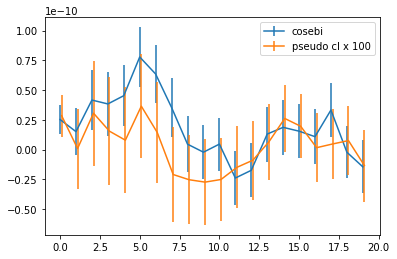

In [204]:
from scipy.interpolate import InterpolatedUnivariateSpline as ius


cd_cosebis = np.zeros((20,n_jck+1))
cd_cosebis_3071 = np.zeros((20,n_jck+1))

# Loop over each COSEBI mode
for ndx in range(20):
    #print (ndx)
    n_ell, n_wn_ell = wnl[ndx] 
    
    # Interpolate
    wnlog_model = ius(n_ell, n_wn_ell)
    
    pbb_model = ius(ell, B_modes_arr[:,0])
    
    ell_eval = np.linspace(ell[0],ell[-1],num=np.int(ell[-1]-ell[0]))
    B_integrand = ius(ell_eval, (ell_eval/(2*np.pi))*wnlog_model(ell_eval)*pbb_model(ell_eval))
    cd_cosebis[ndx,0] = B_integrand.integral(ell[0],ell[-1])

    
    for jk in range(n_jck):
        pbb_model = ius(ell, B_modes_arr[:,jk+1])
        # Get COSEBI for this mode
        ell_eval = np.linspace(ell[0],ell[-1],num=10*np.int(ell[-1]-ell[0]))
        B_integrand = ius(ell_eval, (ell_eval/(2*np.pi))*wnlog_model(ell_eval)*pbb_model(ell_eval))
        cd_cosebis[ndx,jk+1] = B_integrand.integral(ell[0],ell[-1])
    


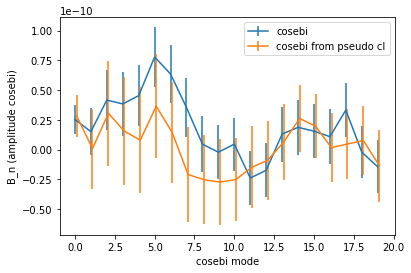

In [239]:
#plt.errorbar(np.arange(len(cosebi_e)),cosebi_e,err_e)
plt.errorbar(np.arange(len(cosebi_b)),cosebi_b,err_b,label='cosebi')

m = covariance_jck(cd_cosebis[:,1:],1000,'jackknife')
plt.ylabel('B_n (amplitude cosebi)')
plt.xlabel('cosebi mode')
plt.errorbar(np.arange(len(cd_cosebis[:,0]))+0.1, cd_cosebis[:,0]*1., m['err']*1.,label='cosebi from pseudo cl')
plt.legend()